# Logistic Regression Model for Magazine Publisher
**Author: Yuxin Deng**

### Goal:  Implement logistic regression model that helps stakeholders understand what drives user's subscribe to our magazine. 
* **Data Layer:** Tagging users by analysis of user consumption behavior.
* **Algorithm Layer:** Use logistic regression to predict when people are going to subscribe.
* **Business Layer:** Determine the methods of keeping customers and pulling new customers.

In [1]:
#Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt 

from imblearn.over_sampling import SMOTE
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier

## Part 1 - Exploratory Data Analysis

### Reading and Checking  Data

In [2]:
# Collect and Read Data
df = pd.read_csv ('marketing_campaign.csv', delimiter = ";")
df.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [3]:
# Check the Shape of Data
df.shape

(2240, 29)

In [4]:
# Set ID as Index
df = df.set_index('ID')
df.head(5)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,0,0,0,0,0,0,3,11,0


### Handing Missing Values

In [5]:
# Finding Missing Value
df.isnull() 
print(df.isnull().sum())  #24 missing valuse in 'Income' column 

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [6]:
# Missing Values' Percentage of 'down' Column 
print(len(df["Income"][pd.isnull(df["Income"])])/len(df))

0.010714285714285714


Column 'Income' has 24 missing values. The percent of missing values in total records is about 1%, so drop the rows with missing values will not cause any huge impact for the final result. 

In [7]:
# Drop Missing Values
df.dropna(axis=0,inplace=True)

In [8]:
# Check the Shape of Data Without Missing Values
df.shape

(2216, 28)

### Feature Engineering

In [9]:
# Change 'Year_Birth' to 'Age'
df['Age'] = 2014 - df['Year_Birth']
df= df.drop(columns="Year_Birth")


In [10]:
# Change 'Dt_Customer' Format from Date to Days

def days_since(dates_series, date_format):
    n = len(dates_series)
    result = [0] * n
    
    for i in range(n):
        result[i] = (datetime(year=2014, month=12, day=31)-datetime.strptime(dates_series[i], date_format)).days
    return result



df["Enrolment_Days"] = days_since(list(df.Dt_Customer), "%Y-%m-%d")
df= df.drop(columns="Dt_Customer")


In [11]:
# Change the Column Order
cols = list(df)
cols.insert(4,cols.pop(cols.index('Age')))
cols.insert(8,cols.pop(cols.index('Enrolment_Days')))
df.loc[:,cols]
df.head(5)

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Enrolment_Days
ID,,,,,,,,,,,,,,,,,,,,,
5524,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,3,11,1,57,848
2174,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,3,11,0,60,298
4141,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,3,11,0,49,497
6182,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,3,11,0,30,324
5324,PhD,Married,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,3,11,0,33,346


### Outlier Detection and Treatment 

#### Numerical Variables

Method: Tukey’s box plot (IQR)
* The statistics (IQR) are robust to outliers, meaning to find one outlier is independent of all other outliers.
* The statistics are easy to calculate. 
* The method does not require a normal distribution of the data.

#### *Variable 'Income'* 

-14525.5 118350.5


(2208, 28)

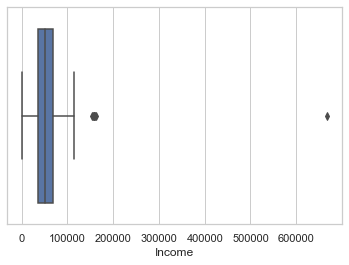

In [12]:
# Check Outlier Using Boxplot
sns.set(style="whitegrid", color_codes=True)
sns.boxplot(data=df,x=df['Income'])

# Outlier Implementation
Q1=df['Income'].quantile(0.25)
Q3=df['Income'].quantile(0.75)
IQR=Q3-Q1
Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print(Lower_Whisker, Upper_Whisker)

# Outlier Treatment 
df = df[df['Income']< Upper_Whisker]

# Check the Shape of Data
df.shape 

#### *Variable 'Age'* 

10.0 82.0


(2205, 28)

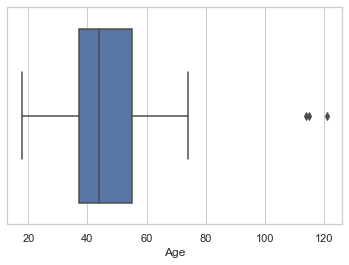

In [13]:
# Check Outlier Using Boxplot
sns.boxplot(data=df,x=df['Age'])

# Outlier Implementation
Q1=df['Age'].quantile(0.25)
Q3=df['Age'].quantile(0.75)
IQR=Q3-Q1
Lower_Whisker = Q1-1.5*IQR
Upper_Whisker = Q3+1.5*IQR
print(Lower_Whisker, Upper_Whisker)

# Outlier Treatment 
df = df[df['Age']< Upper_Whisker]

# Check the Shape of Data
df.shape 

#### *Categorical Variables*  [Human Error]
Combine the category in a column with same meanning and check other human error making abnormality.

#### *Variable 'Education'* 

In [14]:
# Check Categories of 'Education' Column
df["Education"].value_counts()

Graduation    1113
PhD            476
Master         364
2n Cycle       198
Basic           54
Name: Education, dtype: int64

In [15]:
# Group the Same Categories
df['Education']=np.where(df['Education'] =='Graduation', 'Undergraduate', df['Education'])
df['Education']=np.where(df['Education'] =='Basic', 'Undergraduate', df['Education'])
df['Education']=np.where(df['Education'] =='2n Cycle', 'Undergraduate', df['Education'])
df["Education"].unique()

array(['Undergraduate', 'PhD', 'Master'], dtype=object)

#### *Variable 'Marital_Status'* 

In [16]:
# Check Categories of 'Marital_Status' Column
df["Marital_Status"].value_counts()

Married     854
Together    568
Single      470
Divorced    230
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

In [17]:
# Group the Same Categories
df['Marital_Status']=np.where(df['Marital_Status'] =='Together', 'Married', df['Marital_Status'])
df['Marital_Status']=np.where(df['Marital_Status'] =='Widow', 'Single', df['Marital_Status'])
df['Marital_Status']=np.where(df['Marital_Status'] =='Alone', 'Single', df['Marital_Status'])
df[df.Marital_Status != 'YOLO']
df[df.Marital_Status != 'Absurd']
index1 = df[ df['Marital_Status'] == 'YOLO'].index
df.drop(index1 , inplace=True)
index2 = df[ df['Marital_Status'] == 'Absurd'].index
df.drop(index2 , inplace=True)
df["Marital_Status"].unique()

array(['Single', 'Married', 'Divorced'], dtype=object)

### Exploration and Visualizations

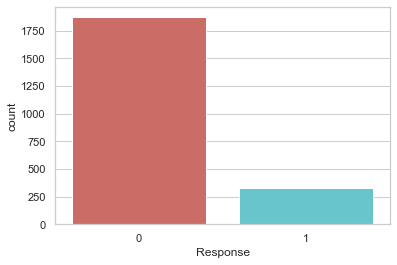

percentage of no subscription is 84.96
percentage of subscription is 15.04


In [18]:
# Check the Percentage of Subscrib in the Dataset
sns.countplot(x=df['Response'], palette = 'hls')
plt.rc("font", size=14)
plt.show()

count_no_sub = len(df[df['Response']==0])
count_sub = len(df[df['Response']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of no subscription is", round(pct_of_no_sub*100,2))
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of subscription is", round(pct_of_sub*100,2))


Our classes are imbalanced, and the ratio of no-subscription to subscription instances is 85:15. Before we go ahead to balance the classes, let’s do some more exploration.

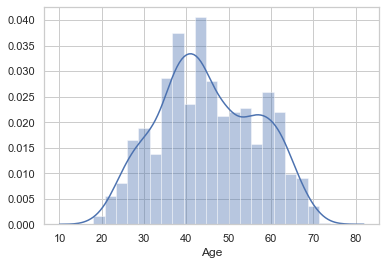

In [19]:
# Distribution of Age
sns.distplot(df['Age'])

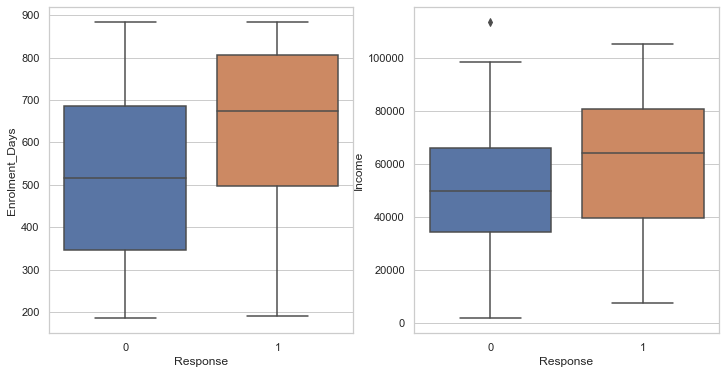

In [20]:
# Comparing Enrolment Days and Income in Two Groups
fig, axis = plt.subplots(1, 2, figsize=(12, 6))
ax=sns.boxplot(x = df['Response'],y = df['Enrolment_Days'], ax=axis[0])
ax=sns.boxplot(x = df['Response'],y = df['Income'], ax=axis[1])

plt.show()

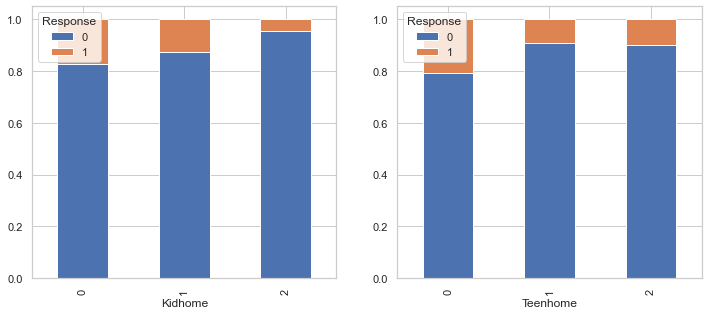

In [21]:
# Checking the Influence of the Number of Kids and Teenagers 
fig, axis = plt.subplots(1, 2, figsize=(12, 5))

table=pd.crosstab(df.Kidhome,df.Response)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar', stacked=True, ax=axis[0])

table=pd.crosstab(df.Teenhome,df.Response)
table.div(table.sum(1).astype(float),axis=0).plot(kind='bar', stacked=True, ax=axis[1])



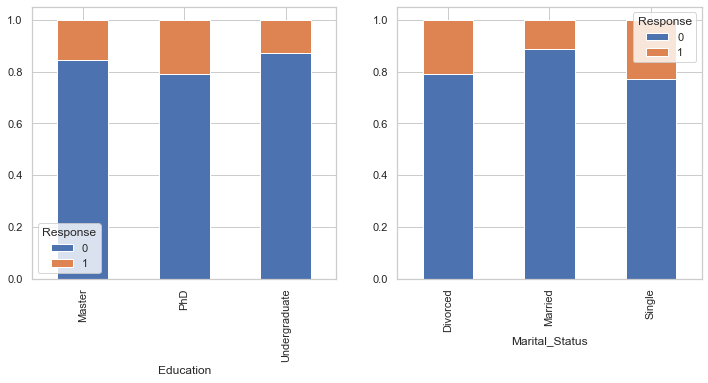

In [22]:
# Checking the Influence of the Education and Marital Status 
fig, axis = plt.subplots(1, 2, figsize=(12, 5))

table=pd.crosstab(df.Education,df.Response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axis[0])

table=pd.crosstab(df.Marital_Status,df.Response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, ax=axis[1])




### Observations:
* Most of readers in this dataset are in the age range of 35–45.
* The average income of customers who subscribe the magazine is higher than that of the customers who didn’t.
* The enrolment days is understandably higher for the customers who bought it. 
* Customers who have Phd degree are more likely subscribe the magazine. Therefore, education seems a good predictor of the outcome variable.
* Surprisingly, single and divorced customers have higher possibale to subscribe the magazine.

## Part 2 - Logistics Regression 

### Dummy Variables

In [23]:
# Create dummy variables
cat_vars=['Education','Marital_Status','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Complain']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1
cat_vars=['Education','Marital_Status','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Complain']
data_vars=df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]


In [24]:
# Check Final Data Columns
data_final=df[to_keep]
data_final.columns.values

array(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Enrolment_Days', 'Education_Master', 'Education_PhD',
       'Education_Undergraduate', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'AcceptedCmp1_0', 'AcceptedCmp1_1', 'AcceptedCmp2_0',
       'AcceptedCmp2_1', 'AcceptedCmp3_0', 'AcceptedCmp3_1',
       'AcceptedCmp4_0', 'AcceptedCmp4_1', 'AcceptedCmp5_0',
       'AcceptedCmp5_1', 'Complain_0', 'Complain_1'], dtype=object)

### Over-sampling using SMOTE

With our training data created, I’ll up-sample the no-subscription using the SMOTE algorithm(Synthetic Minority Oversampling Technique). At a high level, SMOTE:
* Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
* Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [25]:
# Implement SMOT

X = data_final.loc[:, data_final.columns != 'Response']
y = data_final.loc[:, data_final.columns == 'Response']


os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Response'])


In [26]:
# Check the Number of Data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['Response']==0]))
print("Number of subscription",len(os_data_y[os_data_y['Response']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['Response']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['Response']==1])/len(os_data_X))


length of oversampled data is  2626
Number of no subscription in oversampled data 1313
Number of subscription 1313
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


Now we have a perfect balanced data! I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

### Recursive Feature Elimination

Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

In [27]:
# Recursive Feature Elimination
import warnings
warnings.filterwarnings("ignore")

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

data_final_vars=data_final.columns.values.tolist()
y=['Response']
X=[i for i in data_final_vars if i not in y]

logreg = LogisticRegression()

rfe = RFE(logreg, 15)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())




In [28]:
# Show the Result
print(rfe.support_)
print(rfe.ranking_)

[False False  True False False False False False False False False False
 False False False False  True False False  True  True  True  True  True
  True False False  True False  True  True  True  True  True  True False
 False]
[23  8  1 12 20 19 16 18 22 15  6 13 10 11  9  5  1 14 21  1  1  1  1  1
  1  2  3  1  4  1  1  1  1  1  1 17  7]


In [29]:
# Select the Features Baesd on the RFE
cols=['AcceptedCmp5_0','AcceptedCmp3_0', 'AcceptedCmp3_1','AcceptedCmp2_0','Education_Master', 'Education_PhD',
      'Education_Undergraduate', 'Marital_Status_Divorced','Marital_Status_Married', 'Marital_Status_Single'] 
X=os_data_X[cols]
y=os_data_y['Response']

In [30]:
#Implementing the model

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.486500
         Iterations 7
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.298      
Dependent Variable:   Response           AIC:                2575.0972  
Date:                 2021-01-01 17:59   BIC:                2633.8293  
No. Observations:     2626               Log-Likelihood:     -1277.5    
Df Model:             9                  LL-Null:            -1820.2    
Df Residuals:         2616               LLR p-value:        6.8474e-228
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       7.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
AcceptedCmp5_0          -1.1393   0.1452  -7.8449 0

The p-values for most of the variables are smaller than 0.05, except AcceptedCmp3_0, therefore, I will remove it.

In [31]:
cols=['AcceptedCmp5_0', 'AcceptedCmp3_1','AcceptedCmp2_0','Education_Master', 'Education_PhD',
      'Education_Undergraduate', 'Marital_Status_Divorced','Marital_Status_Married', 'Marital_Status_Single'] 
X=os_data_X[cols]
y=os_data_y['Response']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.486604
         Iterations 7
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.298      
Dependent Variable:   Response           AIC:                2573.6439  
Date:                 2021-01-01 17:59   BIC:                2626.5028  
No. Observations:     2626               Log-Likelihood:     -1277.8    
Df Model:             8                  LL-Null:            -1820.2    
Df Residuals:         2617               LLR p-value:        7.4716e-229
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       7.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
AcceptedCmp5_0          -1.1385   0.1452  -7.8405 0

### Logistic Regression Model Fitting

In [32]:
# Split Dataset into Training Set and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Model Fitting
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [33]:
#Predicting the test set results and calculating the accuracy
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.87


In [34]:
#Confusion Matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[353  21]
 [ 82 332]]


The result is telling us that we have 353+332 correct predictions and 21+82 incorrect predictions.

In [35]:
#Compute precision, recall, F-measure and support
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       374
           1       0.94      0.80      0.87       414

    accuracy                           0.87       788
   macro avg       0.88      0.87      0.87       788
weighted avg       0.88      0.87      0.87       788



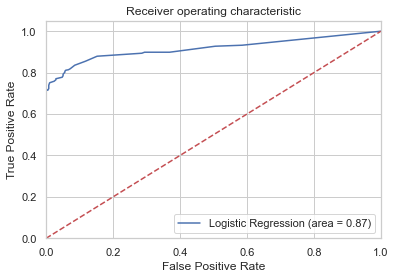

In [36]:
#ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [37]:
# KNN Classification 

#try K value from 1 to 10 to test accuracy
krange = range(1,11)
scores = {}
scores_list =[]
for k in krange:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores[k] =metrics.accuracy_score(y_test,y_pred)
    scores_list.append(metrics.accuracy_score(y_test,y_pred))
    
print(scores_list)

[0.6967005076142132, 0.8642131979695431, 0.8591370558375635, 0.8604060913705583, 0.8616751269035533, 0.8642131979695431, 0.8578680203045685, 0.8591370558375635, 0.8540609137055838, 0.8553299492385786]


Text(0, 0.5, 'Testing Accuracy')

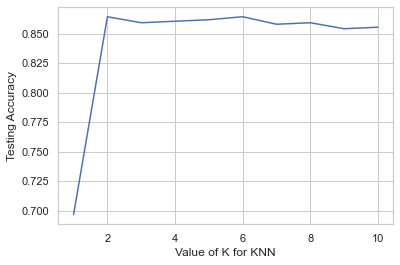

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

#plot the relationship between K and the test accuracy
plt.plot(krange,scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [39]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X,y)

KNeighborsClassifier(n_neighbors=4)